In [1]:
import tensorflow as tf

In [2]:
data = tf.keras.utils.get_file('cats_and_dogs.zip',
                        'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip',
                         extract=True)

In [3]:
data

'C:\\Users\\sunde\\.keras\\datasets\\cats_and_dogs.zip'

In [4]:
import os

In [5]:
os.listdir('C:\\Users\\sunde\\.keras\\datasets\\cats_and_dogs_filtered\\train')

['cats', 'dogs']

In [6]:
import pathlib

In [7]:
train = pathlib.Path('C:\\Users\\sunde\\.keras\\datasets\\cats_and_dogs_filtered\\train')
validation = pathlib.Path('C:\\Users\\sunde\\.keras\\datasets\\cats_and_dogs_filtered\\validation')

In [8]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train, batch_size=64, image_size=(224, 224))
validation_data = tf.keras.preprocessing.image_dataset_from_directory(validation, image_size=(224, 224))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


# 모바일 서비스 (= 성능 감소)

In [9]:
m1 = tf.keras.applications.MobileNet()

In [10]:
m1.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [14]:
m2 = tf.keras.applications.MobileNetV2()

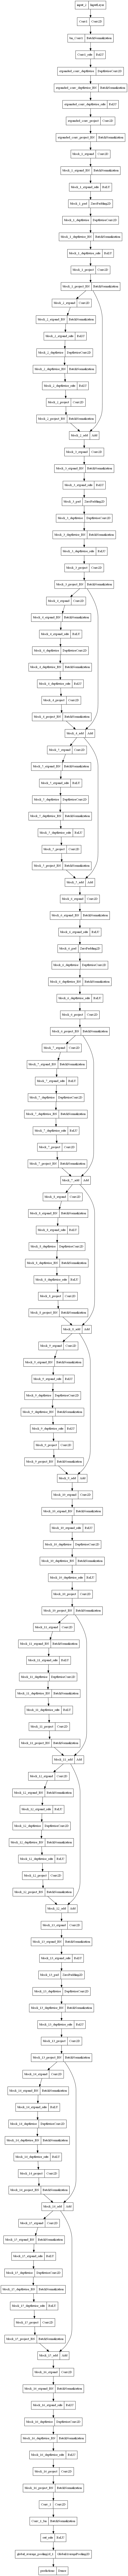

In [15]:
tf.keras.utils.plot_model(m2)

In [ ]:
1. 기존 똑같이
2. 전이 학습
   2.1 Feature Extraction
   2.2 Fine Tuning
     2.2.1
     2.2.1 

# Fine Tuning

In [ ]:
# base_model = backbone의 학습 환경과 똑같은 전처리 기법 사용

In [ ]:
tf.keras.applications.mobilenet_v2.preprocess_input

In [17]:
mobile = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224,224,3))

In [18]:
mobile.summary() # 7x7 Yolo

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [20]:
len(mobile.layers)

154

# target / source (dogvscat)
## 1000

# data size
## 2000/1000

# Flatten / GAP

In [88]:
mobile = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224,224,3))

In [89]:
mobile.trainable = True
for i in mobile.layers[:100]:
    i.trainable = False

In [90]:
input_ = tf.keras.Input((224,224,3))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/127.5, offset=-1)(input_)
x = tf.keras.applications.mobilenet_v2.preprocess_input(input_) # 핵심
x = mobile(x, training=True)
x = tf.keras.layers.GlobalAvgPool2D()(x)
x = tf.keras.layers.Dense(1)(x)

In [91]:
model = tf.keras.Model(input_, x)

In [92]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(0.001), # FT 핵심
              metrics=['accuracy'])

In [93]:
history = model.fit(train_data, validation_data=validation_data, epochs=10, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Epoch 1/10
32/32 [==============================] - 23s 626ms/step - loss: 0.1587 - accuracy: 0.9250 - val_loss: 0.1386 - val_accuracy: 0.9460
Epoch 2/10
 4/32 [==>...........................] - ETA: 12s - loss: 0.0588 - accuracy: 0.9766

KeyboardInterrupt: 

# Feature Extraction
= 기존의 지식은 내 전용으로 모델 만들 때, 학습 시키지 않고 그대로 사용

In [160]:
vgg = tf.keras.applications.VGG16(include_top=False)

# 가져옴

In [161]:
vgg.trainable = False # freezing (Feature Extraction)

In [162]:
vgg.trainable = True  # unfreezing (Fine Tuning)

In [ ]:
1000개 분류용
- FE : 개/고양이 분류 능력 확보 : FC > 
- FT : 개/고양이 분류 능력 확보 but 조금 부족함 > 내 도메인에 맞쳐서 조금 미세하게 기존 학습한 웨이트 수정하자!!

In [ ]:
개 능력 확보 
- FE : 고양이 분류 능력 가능
- FT :                  but 조금 부족함 > 고양이 데이터 가지고 미세하게 (low learning rate) > catastrophic fogetting

In [163]:
# importance
for i in vgg.layers[:]: # mutable
    i.trainable = False

In [164]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [181]:
input_ = tf.keras.Input((224,224,3))

In [182]:
x = vgg(input_, training=True)

In [183]:
# x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.GlobalAvgPool2D()(x)

In [184]:
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(1)(x)

In [185]:
model = tf.keras.Model(input_, x)

In [186]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_17 (Dense)            (None, 64)                32832     
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 14,747,585
Trainable params: 32,897
Non-trainable params: 14,714,688
__________________________________________

In [187]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['acc'])

In [172]:
history = model.fit(train_data, validation_data=validation_data, epochs=10)

Epoch 1/10
32/32 [==============================] - 18s 539ms/step - loss: 0.6252 - acc: 0.8635 - val_loss: 0.1565 - val_acc: 0.9370
Epoch 2/10
32/32 [==============================] - 16s 516ms/step - loss: 0.1481 - acc: 0.9455 - val_loss: 0.1033 - val_acc: 0.9660
Epoch 3/10
32/32 [==============================] - 17s 517ms/step - loss: 0.1128 - acc: 0.9570 - val_loss: 0.1015 - val_acc: 0.9690
Epoch 4/10
32/32 [==============================] - 16s 515ms/step - loss: 0.0594 - acc: 0.9780 - val_loss: 0.2056 - val_acc: 0.9410
Epoch 5/10
32/32 [==============================] - 17s 517ms/step - loss: 0.0618 - acc: 0.9765 - val_loss: 0.0977 - val_acc: 0.9710
Epoch 6/10
32/32 [==============================] - 17s 518ms/step - loss: 0.0231 - acc: 0.9940 - val_loss: 0.2603 - val_acc: 0.9210
Epoch 7/10
32/32 [==============================] - 17s 517ms/step - loss: 0.0371 - acc: 0.9840 - val_loss: 0.1570 - val_acc: 0.9620
Epoch 8/10
32/32 [==============================] - 17s 518ms/step - 

In [156]:
history = model.fit(train_data, validation_data=validation_data, epochs=10)

Epoch 1/10
32/32 [==============================] - 22s 688ms/step - loss: 0.7360 - acc: 0.8465 - val_loss: 0.2982 - val_acc: 0.9085
Epoch 2/10
32/32 [==============================] - 22s 689ms/step - loss: 0.1640 - acc: 0.9465 - val_loss: 0.0854 - val_acc: 0.9730
Epoch 3/10
32/32 [==============================] - 22s 692ms/step - loss: 0.1249 - acc: 0.9650 - val_loss: 0.0689 - val_acc: 0.9640
Epoch 4/10
32/32 [==============================] - 22s 692ms/step - loss: 0.0653 - acc: 0.9745 - val_loss: 0.4779 - val_acc: 0.8750
Epoch 5/10
32/32 [==============================] - 22s 692ms/step - loss: 0.0435 - acc: 0.9860 - val_loss: 0.0093 - val_acc: 0.9975
Epoch 6/10
32/32 [==============================] - 22s 694ms/step - loss: 0.0487 - acc: 0.9815 - val_loss: 0.1142 - val_acc: 0.9535
Epoch 7/10
32/32 [==============================] - 22s 694ms/step - loss: 0.0375 - acc: 0.9885 - val_loss: 0.0062 - val_acc: 0.9990
Epoch 8/10
32/32 [==============================] - 22s 693ms/step - 

In [173]:
import pandas as pd

<AxesSubplot:>

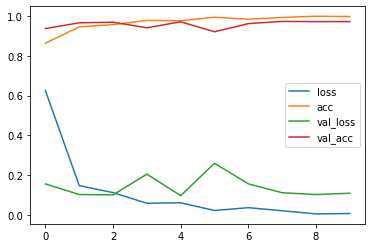

In [174]:
pd.DataFrame(history.history).plot.line()

In [ ]:
flattern
GAP

In [87]:
resnet = tf.keras.applications.ResNet50(include_top=False)

94781440/94765736 [==============================] - 2s 0us/step


In [88]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [78]:
!pip install -U model-profiler

In [77]:
import model_profiler

In [136]:
print(model_profiler.model_profiler(resnet, 64))

| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.3892  | BFLOPs  |
| GPU Memory Requirement           | 0.0437  | GB      |
| Model Parameters                 | 23.5877 | Million |
| Memory Required by Model Weights | 89.98   | MB      |


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


# transfer learning
- 2010 pre deep-learning 
- deep learning : feature representaion transfer 
                  - feature extraction
                  - fine tuning

In [ ]:
cats : 1000
dogs : 1000
# balanced datasets

# Functional Model

In [ ]:
training=True <- default (생략가능)

In [ ]:
transfer learning 
1. freeze (no update) > training=False
2. fine tuning (update) > training=True, 생략